In [1]:
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division
import pickle
import random
import math
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from scipy.stats import pearsonr

In [2]:
data_dir = '../data'

vid_dirs = [
    './data/animations_all/HH/Style1/7',
    './data/animations_all/HH/Style1/10',
    './data/animations_all/HH/Style1/20',
    './data/animations_all/HH/Style1/50',
    './data/animations_all/HH/Style1/100',
    './data/animations_all/HH/Style2/7',
    './data/animations_all/HH/Style2/10',
    './data/animations_all/HH/Style2/20',
    './data/animations_all/HH/Style2/50',
    './data/animations_all/HH/Style2/100',
    './data/animations_all/HO/Style1',
    './data/animations_all/HO/Style2',
    './data/animations_all/HO/Style3',
    './data/animations_all/OO/collision',
    './data/animations_all/OO/rod',
    './data/animations_all/OO/rope',
    './data/animations_all/OO/spring',
]

general_types = [
0,
1,
2,
3,
4,
0,
1,
2,
3,
4,
5,
5,
5,
6,
7,
8,
9
]
markers = {0: 'o', 1: 'o', 2: 'o', 3: 'o', 4: 'o',
           5: '^', 6: 's', 7: 's', 8: 's', 9: 's'}

In [3]:
"""load human responses"""
response_file_name = data_dir + '/human_responses_exp1.txt'
HH, OO, HO = [], [], []
with open(response_file_name) as f:
    for line in f:
        res = [float(x) for x in line.split()]
        HH.append(res[0] / sum(res[:3]))
        OO.append(res[1] / sum(res[:3]))
        HO.append(res[2] / sum(res[:3]))
GT_types = []
for vid_type, vid_dir in enumerate(vid_dirs):
    GT_types += [general_types[vid_type]] * 50

In [4]:
"""load and preprocess model results"""
def load_model_results(train_size, model='ours'):
    max_loss = 0.5
    D1, D2, D_all = [], [], [] # deviations of each entity + average of both entities
    L1, L2, L_all = [], [], [] # log-likelihood ratios of each entity + average of both entities
    ll_ratios = pickle.load(open(data_dir + '/{}L_{}.pik'.format('' if model == 'ours' else model + '_', train_size), 'rb'))
    loss_all = [pickle.load(open(data_dir + '/{}D_{}_{}.pik'.format('' if model == 'ours' else model + '_', dataset, train_size), 'rb'))
                for dataset in ['collision', 'spring']]
    for vid_dir in vid_dirs:
        losses = [loss[vid_dir] for loss in loss_all]
        for i, vid_id in enumerate(range(1, 100, 2)):
            if model == 'ours':
                L1_1 = ll_ratios[vid_dir][0][i][0:].mean()
                L1_2 = ll_ratios[vid_dir][1][i][0:].mean()
                L2_1 = ll_ratios[vid_dir][2][i][0:].mean()
                L2_2 = ll_ratios[vid_dir][3][i][0:].mean()
            else:
                L1_1 = ll_ratios[vid_dir][0][i]
                L1_2 = ll_ratios[vid_dir][1][i]
                L2_1 = ll_ratios[vid_dir][2][i]
                L2_2 = ll_ratios[vid_dir][3][i]

            # select the best goal combinations
            best = -1e6
            if L1_1 + L2_1 > best:
                best = L1_1 + L2_1
                L1_mean, L2_mean = L1_1, L2_1
            if L1_1 + L2_2 > best:
                best = L1_1 + L2_2
                L1_mean, L2_mean = L1_1, L2_2
            if L1_2 + L2_1 > best:
                best = L1_2 + L2_1
                L1_mean, L2_mean = L1_2, L2_1
            if L1_2 + L2_2 > best:
                best = L1_2 + L2_2
                L1_mean, L2_mean = L1_2, L2_2
    #         L_all.append(max(0, (L1_mean + L2_mean) * 0.5))
            L_all.append((L1_mean + L2_mean) * 0.5)
            L1.append(L1_mean)
            L2.append(L2_mean)

            # select the best physical configurations
            loss_1, loss_2 = 1e8, 1e8
            min_loss = 1e8
            for D in losses:
                cur_loss = np.array(D[i][0][0:]).clip(0,max_loss).mean() + np.array(D[i][1][0:]).clip(0,max_loss).mean()
                if cur_loss < min_loss:
                    min_loss = cur_loss
                    loss_1, loss_2 = np.array(D[i][0][0:]).clip(0,max_loss), np.array(D[i][1][0:]).clip(0,max_loss)
            D_all.append(0.5 * ((loss_1.mean() + loss_2.mean())))
            D1.append(loss_1.mean())
            D2.append(loss_2.mean())
    #         print(vid_id, L1_mean, L2_mean, D1[-1], D2[-1])
    return D1, D2, D_all, L1, L2, L_all

In [5]:
def get_types(D_all, L_all, num_videos_per_type, N, exclude_types=[]):
    """get """
    Ds, Ls = [], []
    HHs, HOs, OOs, colors = [], [], [], []
    types = []
    start = 0
    for vid_type, vid_dir in enumerate(vid_dirs):
        if general_types[vid_type] not in exclude_types:
            types += [general_types[vid_type]] * (50 // N)
            for i in range(0, num_videos_per_type // N):
                Ds.append(sum(D_all[start + i * N : start + (i + 1) * N]) / N)
                Ls.append(sum(L_all[start + i * N : start + (i + 1) * N]) / N)
                cur_OO = sum(OO[start + i * N : start + (i + 1) * N]) / N
                cur_HO = sum(HO[start + i * N : start + (i + 1) * N]) / N
                cur_HH = sum(HH[start + i * N : start + (i + 1) * N]) / N
                OOs.append(cur_OO)
                HOs.append(cur_HO)
                HHs.append(cur_HH)
                colors.append((cur_HH, cur_HO, cur_OO))
        start += num_videos_per_type
    return Ds, Ls, HHs, HOs, OOs, colors, types

In [6]:
def get_viz_datapoints(D_all, L_all, num_videos_per_type, N, exclude_types=[]):
    """get data points for visualization"""
    Ds, Ls = [], []
    HHs, HOs, OOs, colors = [], [], [], []
    types = []
    start = 0
    for vid_type, vid_dir in enumerate(vid_dirs):
        if general_types[vid_type] not in exclude_types:
            types += [general_types[vid_type]] * (50 // N)
            for i in range(0, num_videos_per_type // N):
                Ds.append(sum(D_all[start + i * N : start + (i + 1) * N]) / N)
                Ls.append(sum(L_all[start + i * N : start + (i + 1) * N]) / N)
                cur_OO = sum(OO[start + i * N : start + (i + 1) * N]) / N
                cur_HO = sum(HO[start + i * N : start + (i + 1) * N]) / N
                cur_HH = sum(HH[start + i * N : start + (i + 1) * N]) / N
                OOs.append(cur_OO)
                HOs.append(cur_HO)
                HHs.append(cur_HH)
                colors.append((cur_HH, cur_HO, cur_OO))
        start += num_videos_per_type
    return Ds, Ls, HHs, HOs, OOs, colors, types

In [7]:
"""Visualizing individual stimuli (100% HH + HO + OO)"""
def viz_ind(train_size, D_all, L_all, model):
    num_videos_per_type = 50
    N = 1
    Ds, Ls, HHs, HOs, OOs, colors, types = get_viz_datapoints(D_all, L_all, num_videos_per_type, N, exclude_types=[0,1,2,3])
    ms = [markers[type_id] for type_id in types]

    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(111, frameon=True)
    ax.set_xlabel('Dev. from Pred. of Phys. Model', fontsize=18)
    ax.set_ylabel('Intention', fontsize=18)
    s = 20
    for D, L, c, m in zip(Ds, Ls, colors, ms):
        plt.scatter(x=D, y=L,
                    c=np.array(c).reshape(1,-1), s=s, marker=m)

    legend_elements = [Line2D([0], [0], marker='s', color='w', label='HH',
                          markerfacecolor=(0.900, 0.2250, 0.0980), markeredgecolor=(0.900, 0.2250, 0.0980), markersize=10),
                      Line2D([0], [0], marker='s', color='w', label='HO',
                          markerfacecolor=(0, 0.6940, 0.1250), markeredgecolor=(0, 0.6940, 0.1250), markersize=10),
                      Line2D([0], [0], marker='s', color='w', label='OO',
                          markerfacecolor=(0, 0.2470, 0.7410), markeredgecolor=(0, 0.2470, 0.7410), markersize=10)]    
    ax.legend(legend_elements, ['Human-Human Response', 'Human-Object Response', 'Object-Object Response'], 
              bbox_to_anchor=(1.02, 0.5), loc=3, borderaxespad=0., fontsize=14)

    xmin, xmax = -0.02, 0.32
    ymin, ymax = -0.2, 0.48
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    fig.tight_layout()

    fig.savefig('space_individual_{}_{}.pdf'.format(model, train_size))

In [8]:
"""Visualizing centers (all HH + HO + OO)"""
def viz_center(train_size, D_all, L_all, model):
    num_videos_per_type = 50
    N = 50
    Ds, Ls, HHs, HOs, OOs, colors, types = get_viz_datapoints(D_all, L_all, num_videos_per_type, N)

    # get centers
    Ds0 = list(Ds)
    Ls0 = list(Ls)
    colors0 = list(colors)
    Ds, Ls, colors = [], [], []
    ms = []
    for type_id in range(10):
        tmp_D = [D for D, type in zip(Ds0, types) if type == type_id]
        tmp_L = [L for L, type in zip(Ls0, types) if type == type_id]
        tmp_colors = [c for c, type in zip(colors0, types) if type == type_id]
        Ds.append(np.array(tmp_D).mean())
        Ls.append(np.array(tmp_L).mean())
        mean_c = (np.array([c[0] for c in tmp_colors]).mean(), 
                  np.array([c[1] for c in tmp_colors]).mean(), 
                  np.array([c[2] for c in tmp_colors]).mean())
        colors.append(mean_c)
        ms.append(markers[type_id])

    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(111, frameon=True) 
    ax.set_xlabel('Dev. from Pred. of Phys. Model', fontsize=18)
    ax.set_ylabel('Intention', fontsize=18)
    s = 100
    for D, L, c, m in zip(Ds, Ls, colors, ms):
        plt.scatter(x=D, y=L,
                    c=np.array(c).reshape(1,-1), s=s, marker=m)

    legend_elements = [Line2D([0], [0], marker='s', color='w', label='HH',
                          markerfacecolor=(0.900, 0.2250, 0.0980), markeredgecolor=(0.900, 0.2250, 0.0980), markersize=10),
                      Line2D([0], [0], marker='s', color='w', label='HO',
                          markerfacecolor=(0, 0.6940, 0.1250), markeredgecolor=(0, 0.6940, 0.1250), markersize=10),
                      Line2D([0], [0], marker='s', color='w', label='OO',
                          markerfacecolor=(0, 0.2470, 0.7410), markeredgecolor=(0, 0.2470, 0.7410), markersize=10)]    
    ax.legend(legend_elements, ['Human-Human Response', 'Human-Object Response', 'Object-Object Response'], 
              bbox_to_anchor=(1.02, 0.5), loc=3, borderaxespad=0., fontsize=14)

    str_list = ['7%', '10%', '20%', '50%', '100%', '', 'collision', 'rod', 'soft rope', 'spring']
    for id, (x, y, s) in enumerate(zip(Ds, Ls, str_list)):
        dx, dy = 0, 0
        if id == 6:
            dx = 0.005
            dy = -0.01
        if id == 7:
            dx = 0.01
            dy = -0.01
        if id == 8:
            dx = -0.02
            dy = 0.005
        if id == 9:
            dy = -0.005
            dx = 0.01
        if id < 6:
            plt.text(x=x - 0.01, y=y - 0.02, 
                     s=s, fontsize=12, fontweight='bold')
        else:
            plt.text(x=x - 0.002 + dx, y=y + 0.005 + dy, 
                     s=s, fontsize=12, fontweight='bold')
    # ax.set_xlim(xmin, xmax)
    # ax.set_ylim(ymin, ymax)

    fig.tight_layout()

    fig.savefig('space_centers_{}_{}.pdf'.format(model, train_size))

In [9]:
"""model predictions based on D and L"""
import scipy.optimize as opt
from scipy.stats import multivariate_normal

def model_pred(D_all, L_all, beta=1.0, exclude_types=[0,1,2,3], num_rounds=100):

    def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
        (x, y) = xdata_tuple
        xo = float(xo)
        yo = float(yo)    
        a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
        b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
        c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
        g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                                + c*((y-yo)**2)))
        return g.ravel()


    num_videos_per_type = 50
    N = 1
    Ds, Ls, HHs, HOs, OOs, colors, types = get_viz_datapoints(D_all, L_all, num_videos_per_type, N, exclude_types=exclude_types)
    with open('../data/D_exp1.txt', 'w') as filehandle:
        for listitem in Ds:
            filehandle.write('%f\n' % listitem)
    with open('../data/L_exp1.txt', 'w') as filehandle:
        for listitem in Ls:
            filehandle.write('%f\n' % listitem)
    with open('../data/HH_exp1.txt', 'w') as filehandle:
        for listitem in HHs:
            filehandle.write('%f\n' % listitem)
    with open('../data/HO_exp1.txt', 'w') as filehandle:
        for listitem in HOs:
            filehandle.write('%f\n' % listitem)
    with open('../data/OO_exp1.txt', 'w') as filehandle:
        for listitem in OOs:
            filehandle.write('%f\n' % listitem)
    with open('../data/types_exp1.txt', 'w') as filehandle:
        for listitem in types:
            filehandle.write('%d\n' % listitem)
    
    
    # 2-fold cross-validation
    random.seed(1)
    corr_list = [None] * num_rounds
    model_preds_HH = {i: [] for i in range(len(Ds))}
    model_preds_HO = {i: [] for i in range(len(Ds))}
    model_preds_OO = {i: [] for i in range(len(Ds))}
    for round_id in range(num_rounds):
        indices = list(range(len(Ds)))
        random.shuffle(indices)
        N_train = int(len(indices) / 2)
        train_indices = list(indices[:N_train])
        test_indices = list(indices[N_train:])

        X, Y = np.array(Ds), np.array(Ls)
        X_train, Y_train = np.array([Ds[i] for i in train_indices]), np.array([Ls[i] for i in train_indices])
        X_test, Y_test = np.array([Ds[i] for i in test_indices]), np.array([Ls[i] for i in test_indices])
        types_train, types_test = [types[i] for i in train_indices], [types[i] for i in test_indices]
        data_HH_train = np.array([HHs[i] for i in train_indices])
        data_HH_test = np.array([HHs[i] for i in test_indices])
        data_HO_train = np.array([HOs[i] for i in train_indices])
        data_HO_test = np.array([HOs[i] for i in test_indices])
        data_OO_train = np.array([OOs[i] for i in train_indices])
        data_OO_test = np.array([OOs[i] for i in test_indices])
        data_GT_all = np.vstack([data_HH_test, data_HO_test, data_OO_test]).transpose().reshape(-1)

        # likelihood for HH
        X_train_HH, Y_train_HH = np.array([x for x, type in zip(X_train, types_train) if type < 5]), \
                                 np.array([y for y, type in zip(Y_train, types_train) if type < 5])
        coord_train_HH = np.stack([X_train_HH, Y_train_HH]).transpose()
        mean_HH = np.mean(coord_train_HH, axis=0)
        cov_HH = np.cov(coord_train_HH, rowvar=0)
        p_HH = multivariate_normal.pdf(np.stack([X_test, Y_test]).transpose(), mean_HH, cov_HH)

        # likelihood for HO
        X_train_HO, Y_train_HO = np.array([x for x, type in zip(X_train, types_train) if type == 5]), \
                                 np.array([y for y, type in zip(Y_train, types_train) if type == 5])
        coord_train_HO = np.stack([X_train_HO, Y_train_HO]).transpose()
        mean_HO = np.mean(coord_train_HO, axis=0)
        cov_HO = np.cov(coord_train_HO, rowvar=0)
        p_HO = multivariate_normal.pdf(np.stack([X_test, Y_test]).transpose(), mean_HO, cov_HO)

        # likelihood for OO
        X_train_OO, Y_train_OO = np.array([x for x, type in zip(X_train, types_train) if type > 5]), \
                                 np.array([y for y, type in zip(Y_train, types_train) if type > 5])
        coord_train_OO = np.stack([X_train_OO, Y_train_OO]).transpose()
        mean_OO = np.mean(coord_train_OO, axis=0)
        cov_OO = np.cov(coord_train_OO, rowvar=0)
        p_OO = multivariate_normal.pdf(np.stack([X_test, Y_test]).transpose(), mean_OO, cov_OO)

        p_pred_sum = p_HH + p_HO + p_OO 
        p_pred_HH = (p_HH / p_pred_sum) ** beta
        p_pred_HO = (p_HO / p_pred_sum) ** beta
        p_pred_OO = (p_OO / p_pred_sum) ** beta
        p_pred_sum = p_pred_HH + p_pred_HO + p_pred_OO
        p_pred_HH /= p_pred_sum
        p_pred_HO /= p_pred_sum
        p_pred_OO /= p_pred_sum
        
        p_pred_all = np.stack([p_pred_HH, p_pred_HO, p_pred_OO]).transpose().reshape(-1)    
        corr_list[round_id] = pearsonr(data_GT_all, p_pred_all)[0]
        for i, hh, ho, oo in zip(test_indices, p_pred_HH, p_pred_HO, p_pred_OO):
            model_preds_HH[i].append(hh)
            model_preds_HO[i].append(ho)
            model_preds_OO[i].append(oo)
    model_HH, model_HO, model_OO = [None] * len(Ds), [None] * len(Ds), [None] * len(Ds)
    corr_all = []
    for i in range(len(Ds)):
        hh, ho, oo = model_preds_HH[i], model_preds_HO[i], model_preds_OO[i]
        model_HH[i], model_HO[i], model_OO[i] = np.mean(hh), np.mean(ho), np.mean(oo)
        corr_all.append(pearsonr([HHs[i], HOs[i], OOs[i]], [model_HH[i], model_HO[i], model_OO[i]])[0])
#         if corr_all[-1] < 0.8:
#             print([HHs[i], HOs[i], OOs[i]], [model_HH[i], model_HO[i], model_OO[i]])
#     print(np.mean(corr_all))
#     print(pearsonr(np.stack([HHs, HOs, OOs]).transpose().reshape(-1), 
#                    np.stack([model_HH, model_HO, model_OO]).transpose().reshape(-1)))
#     print(pearsonr(HHs, model_HH))
#     print(pearsonr(HOs, model_HO))
#     print(pearsonr(OOs, model_OO))
    return corr_list, model_HH, model_HO, model_OO, types

In [10]:
"""histogram of orientations of segments in Experiment 2"""
def viz_hist_ori(train_size, D1, D2, L1, L2, model):
    indices = []
    with open(data_dir + '/indices_exp2.txt') as f:
        for line in f:
            res = [int(x) for x in line.split()]
            indices.append(res[0])

    Hs, Os = [], []
    with open(data_dir + '/human_responses_exp2.txt') as f:
        for line in f:
            res = [int(x) for x in line.split()]
            Hs.append(res[1] / sum(res))
            Os.append(res[0] / sum(res))    

    D1_exp2 = [D1[i] for i in indices]
    L1_exp2 = [L1[i] for i in indices]
    D2_exp2 = [D2[i] for i in indices]
    L2_exp2 = [L2[i] for i in indices]
    colors1 = [(H, 0, O) for H, O in zip(Hs, Os)] # colors for human entities
    colors2 = [(O, 0, H) for H, O in zip(Hs, Os)] # colors for object entities
    
    
    with open('../data/D1_exp2.txt', 'w') as filehandle:
        for listitem in D1_exp2:
            filehandle.write('%f\n' % listitem)
    with open('../data/D2_exp2.txt', 'w') as filehandle:
        for listitem in D2_exp2:
            filehandle.write('%f\n' % listitem)
    with open('../data/L1_exp2.txt', 'w') as filehandle:
        for listitem in L1_exp2:
            filehandle.write('%f\n' % listitem)
    with open('../data/L2_exp2.txt', 'w') as filehandle:
        for listitem in L2_exp2:
            filehandle.write('%f\n' % listitem)
    with open('../data/H1_exp2.txt', 'w') as filehandle:
        for listitem in Hs:
            filehandle.write('%f\n' % listitem)
    with open('../data/H2_exp2.txt', 'w') as filehandle:
        for listitem in Os:
            filehandle.write('%f\n' % listitem)

    fig = plt.figure(figsize=(5, 4))
    ax = fig.add_subplot(111, frameon=True, polar=True) 

    Dmean = np.mean(np.array(D1_exp2 + D2_exp2))
    Dstd = np.std(np.array(D1_exp2 + D2_exp2))
    Lmean = np.mean(np.array(L1_exp2 + L2_exp2))
    Lstd = np.std(np.array(L1_exp2 + L2_exp2))
    # print(Dmean, Dstd, Lmean, Lstd)

    D1_exp2 = [(D - Dmean) / Dstd  for D in D1_exp2]
    L1_exp2 = [(L - Lmean) / Lstd for L in L1_exp2]
    D2_exp2 = [(D - Dmean) / Dstd  for D in D2_exp2]
    L2_exp2 = [(L - Lmean) / Lstd for L in L2_exp2]
    
    with open('../data/D1_exp2_norm.txt', 'w') as filehandle:
        for listitem in D1_exp2:
            filehandle.write('%f\n' % listitem)
    with open('../data/D2_exp2_norm.txt', 'w') as filehandle:
        for listitem in D2_exp2:
            filehandle.write('%f\n' % listitem)
    with open('../data/L1_exp2_norm.txt', 'w') as filehandle:
        for listitem in L1_exp2:
            filehandle.write('%f\n' % listitem)
    with open('../data/L2_exp2_norm.txt', 'w') as filehandle:
        for listitem in L2_exp2:
            filehandle.write('%f\n' % listitem)
    

    sig_thresh = 0.36

    theta_HH_sig = [math.atan2(l1 - l2, d1 - d2) if c1[0] > c2[0] else math.atan2(l2 - l1, d2 - d1)
             for d1, d2, l1, l2, c1, c2 in zip(D1_exp2[:80], D2_exp2[:80], L1_exp2[:80], L2_exp2[:80], colors1[:80], colors2[:80]) if abs(c1[0] - c2[0]) >= sig_thresh]
    theta_HH_nonsig = [math.atan2(l1 - l2, d1 - d2) if c1[0] > c2[0] else math.atan2(l2 - l1, d2 - d1)
             for d1, d2, l1, l2, c1, c2 in zip(D1_exp2[:80], D2_exp2[:80], L1_exp2[:80], L2_exp2[:80], colors1[:80], colors2[:80]) if abs(c1[0] - c2[0]) < sig_thresh]
    theta_HO_sig = [math.atan2(l1 - l2, d1 - d2) if c1[0] > c2[0] else math.atan2(l2 - l1, d2 - d1)
             for d1, d2, l1, l2, c1, c2 in zip(D1_exp2[80:], D2_exp2[80:], L1_exp2[80:], L2_exp2[80:], colors1[80:], colors2[80:]) if abs(c1[0] - c2[0]) >= sig_thresh]
    theta_HO_nonsig = [math.atan2(l1 - l2, d1 - d2) if c1[0] > c2[0] else math.atan2(l2 - l1, d2 - d1)
             for d1, d2, l1, l2, c1, c2 in zip(D1_exp2[80:], D2_exp2[80:], L1_exp2[80:], L2_exp2[80:], colors1[80:], colors2[80:]) if abs(c1[0] - c2[0]) < sig_thresh]
#     print(len(theta_HH_sig), len(theta_HO_sig))
    
    theta_all = [math.atan2(l1 - l2, d1 - d2) if c1[0] > c2[0] else math.atan2(l2 - l1, d2 - d1)
             for d1, d2, l1, l2, c1, c2 in zip(D1_exp2, D2_exp2, L1_exp2, L2_exp2, colors1, colors2)]
    Hs_reordered = [c1[0] - c2[0] if c1[0] > c2[0] else c2[0] - c1[0] for c1, c2 in zip(colors1, colors2)]
    print(pearsonr(theta_all, Hs_reordered))
    
    num_bins = 24
    min_x, max_x = -math.pi, math.pi
    width = 2 * math.pi / num_bins
    bins = [-math.pi + width / 2 + i * width for i in range(num_bins)]
    bars = ax.hist(theta_HH_sig + theta_HH_nonsig, density=False, alpha = 1, bins=bins, range=(min_x, max_x), edgecolor='black')
    bars = ax.hist(theta_HO_sig + theta_HO_nonsig, density=False, alpha = 1, bins=bins, range=(min_x, max_x), edgecolor='black')
    fig.legend(['HH', 'HO'], fontsize=13)
    plt.grid(linewidth=0.5, alpha=0.5)
    fig.tight_layout()
    fig.savefig('theta_hist_{}_{}.pdf'.format(model, train_size))
    
    """visualize representative segments"""
    theta = [math.atan2(l1 - l2, d1 - d2) if c1[0] > c2[0] else math.atan2(l2 - l1, d2 - d1)
             for d1, d2, l1, l2, c1, c2 in zip(D1, D2, L1, L2, colors1, colors2) if c1[0] != c2[0]]

    fig = plt.figure(figsize=(4.3, 4))
    ax = fig.add_subplot(111, frameon=True) 
    ax.set_xlabel('Dev. from Pred. of Phys. Model', fontsize=18)
    ax.set_ylabel('Intention', fontsize=18)
    # visualize videos with the most consistent role judgment (top 5 from HH and HO respectively)
    K = 5
    cnt = 0
    for start_id, end_id in zip([0, 80], [80, 160]):
        ratio = [max(c1[0], c2[0]) for c1, c2 in zip(colors1[start_id:end_id], colors2[start_id:end_id])]
        ranked_indices = list(np.argsort(ratio)[::-1])
        for vid_id, (d1, l1, d2, l2, c1, c2) in enumerate(zip(D1_exp2, L1_exp2, D2_exp2, L2_exp2, colors1, colors2)):
            if c1[0] > c2[0] and l1 < l2 - 0.2 or c1[0] < c2[0] and l1 > l2 + 0.2:
    #             print(id // 50 + 1, id % 50 * 2 + 1, ':', u1, v1, u2, v2, c1[0])
                cnt += 1
            if vid_id - start_id in ranked_indices[:K]:
                plt.plot([d1, d2], [l1, l2], c='black', alpha=0.5)
                plt.scatter(x=d1, y=l1,
                            c=np.array(c1).reshape(1,-1), s=50, marker='o' if c1[0] > c2[0] else 's')
                plt.scatter(x=d2, y=l2,
                            c=np.array(c2).reshape(1,-1), s=50, marker='s' if c1[0] > c2[0] else 'o')
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Entity with higher H response',
                              markerfacecolor='w', markeredgecolor='k', markersize=10),
                       Line2D([0], [0], marker='s', color='w', label='Entity with higher O response',
                              markerfacecolor='w', markeredgecolor='k', markersize=10)]
    ax.legend(legend_elements, ['Human Entity', 'Object Entity'], loc=2,
              bbox_to_anchor=(-0.05, 1.3), ncol=1, fontsize=13)
    ax.axis('scaled')
    fig.tight_layout()

    fig.savefig('segments_top5_{}_{}.pdf'.format(model, train_size))

mean correlation: 0.787, standard dev.: 0.016
(0.08291412142027915, 0.2972435816385851)


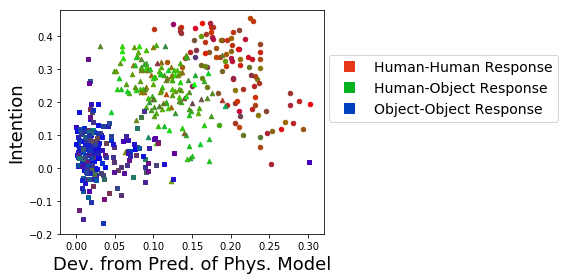

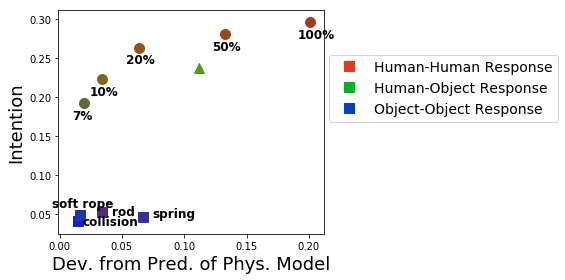

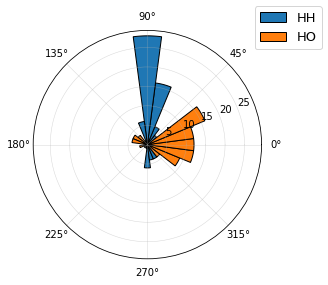

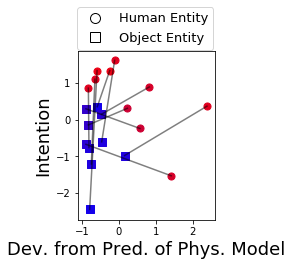

In [11]:
train_size = 50
model = 'ours'
D1, D2, D_all, L1, L2, L_all = load_model_results(train_size, model)
with open('../data/D_exp1_all.txt', 'w') as filehandle:
    for listitem in D_all:
        filehandle.write('%f\n' % listitem)
with open('../data/L_exp1_all.txt', 'w') as filehandle:
    for listitem in L_all:
        filehandle.write('%f\n' % listitem)
viz_ind(train_size, D_all, L_all, model)
viz_center(train_size, D_all, L_all, model)
corr_list, model_HH, model_HO, model_OO, types = model_pred(D_all, L_all, beta=1.0)
print('mean correlation: {}, standard dev.: {}'.format(np.round(np.array(corr_list).mean(), decimals=3), 
                                                       np.round(np.array(corr_list).std(),  decimals=3)))
viz_hist_ori(train_size, D1, D2, L1, L2, model)

In [12]:
def viz_response_hist(HHs, HOs, OOs, types, source):
    means_HH, means_HO, means_OO, stds_HH, stds_HO, stds_OO = [], [], [], [], [], []
    for type_id in range(10):
        tmp_HH = [hh for hh, type in zip(HHs, types) if type == type_id]
        tmp_HO = [ho for ho, type in zip(HOs, types) if type == type_id]
        tmp_OO = [oo for oo, type in zip(OOs, types) if type == type_id]
        means_HH.append(np.mean(tmp_HH)) 
        stds_HH.append(np.std(tmp_HH))
        means_HO.append(np.mean(tmp_HO)) 
        stds_HO.append(np.std(tmp_HO))
        means_OO.append(np.mean(tmp_OO)) 
        stds_OO.append(np.std(tmp_OO))
    tmp_HH, tmp_HO, tmp_OO = [], [], []
    for type_id in [0, 1, 2, 3, 4]:
        tmp_HH += [hh for hh, type in zip(HHs, types) if type == type_id]
        tmp_HO += [ho for ho, type in zip(HOs, types) if type == type_id]
        tmp_OO += [oo for oo, type in zip(OOs, types) if type == type_id]
    mean_all_HH_HH = np.mean(tmp_HH)
    std_all_HH_HH = np.std(tmp_HH)
    mean_all_HH_HO = np.mean(tmp_HO)
    std_all_HH_HO = np.std(tmp_HO)
    mean_all_HH_OO = np.mean(tmp_OO)
    std_all_HH_OO = np.std(tmp_OO)
    tmp_HH, tmp_HO, tmp_OO = [], [], []
    for type_id in [6, 7, 8, 9]:
        tmp_HH += [hh for hh, type in zip(HHs, types) if type == type_id]
        tmp_HO += [ho for ho, type in zip(HOs, types) if type == type_id]
        tmp_OO += [oo for oo, type in zip(OOs, types) if type == type_id]
    mean_all_OO_HH = np.mean(tmp_HH)
    std_all_OO_HH = np.std(tmp_HH)
    mean_all_OO_HO = np.mean(tmp_HO)
    std_all_OO_HO = np.std(tmp_HO)
    mean_all_OO_OO = np.mean(tmp_OO)
    std_all_OO_OO = np.std(tmp_OO)


    fig = plt.figure(figsize=(20, 4))
    ax = fig.add_subplot(111, frameon=True) 
    gs = gridspec.GridSpec(1, 3, width_ratios=[3, 5, 4]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax2 = plt.subplot(gs[2])

    ind=np.array(list(range(3)))
    width = 0.3
    for i in range(3):
        if i == 0:
            tmp = [mean_all_HH_HH, means_HH[5], mean_all_OO_HH]
            tmp_stds = [std_all_HH_HH, stds_OO[5], std_all_OO_HH]
            c = (0.900, 0.2250, 0.0980)
        elif i == 1:
            tmp = [mean_all_HH_HO, means_HO[5], mean_all_OO_HO]
            tmp_stds = [std_all_HH_HO, stds_HO[5], std_all_OO_HO]
            c = (0, 0.6940, 0.1250)
        else:
            tmp = [mean_all_HH_OO, means_OO[5], mean_all_OO_OO]
            tmp_stds = [std_all_HH_OO, stds_OO[5], std_all_OO_OO]
            c = (0, 0.2470, 0.7410)
        ax0.bar(ind+width*i, tmp, width, color=c, yerr=tmp_stds, capsize=3)
    plt.sca(ax0)
    plt.ylim(0,1)
    plt.title('(a) Overall', fontsize=23)
    plt.ylabel('Response proportions' if source == 'human' else 'Model predictions', fontsize=20)
    plt.xticks(ind + width * 1,  ('HH', 'HO', 'OO'), fontsize=20)

    ind=np.array(list(range(5)))
    width = 0.3
    for i in range(3):
        if i == 0:
            tmp = means_HH[:5]
            tmp_stds = stds_HH[:5]
            c = (0.900, 0.2250, 0.0980)
        elif i == 1:
            tmp = means_HO[:5]
            tmp_stds = stds_HO[:5]
            c = (0, 0.6940, 0.1250)
        else:
            tmp = means_OO[:5]
            tmp_stds = stds_OO[:5]
            c = (0, 0.2470, 0.7410)
        ax1.bar(ind+width*i, tmp, width, color=c, yerr=tmp_stds, capsize=3)
    plt.sca(ax1)
    plt.ylim(0,1)
    plt.title('(b) Sub-categories of HH', fontsize=23)
    plt.xticks(ind + width * 1,  ('7%', '10%', '20%', '50%', '100%'), fontsize=20)

    ind=np.array(list(range(4)))
    width = 0.3
    for i in range(3):
        if i == 0:
            tmp = means_HH[6:]
            tmp_stds = stds_HH[6:]
            c = (0.900, 0.2250, 0.0980)
        elif i == 1:
            tmp = means_HO[6:]
            tmp_stds = stds_HO[6:]
            c = (0, 0.6940, 0.1250)
        else:
            tmp = means_OO[6:]
            tmp_stds = stds_OO[6:]
            c = (0, 0.2470, 0.7410)
        ax2.bar(ind+width*i, tmp, width, color=c, yerr=tmp_stds, capsize=3)
    plt.sca(ax2)
    plt.ylim(0,1)
    plt.title('(c) Sub-categories of OO', fontsize=23)
    plt.xticks(ind + width * 1,  ('Collision', 'Rod', 'Soft rope', 'Spring'), fontsize=20)

    plt.sca(ax2)
    plt.legend(['HH Response', 'HO Response', 'OO Response'] if source == 'human' else ['HH Prediction', 'HO Prediction', 'OO Prediction'], 
               fontsize=20, loc='upper left', bbox_to_anchor=(0.87, 1.2))
    fig = plt.gcf()
    fig.set_size_inches(25, 4)
    fig.savefig('./hist_{}.pdf'.format(source))
    fig.tight_layout()

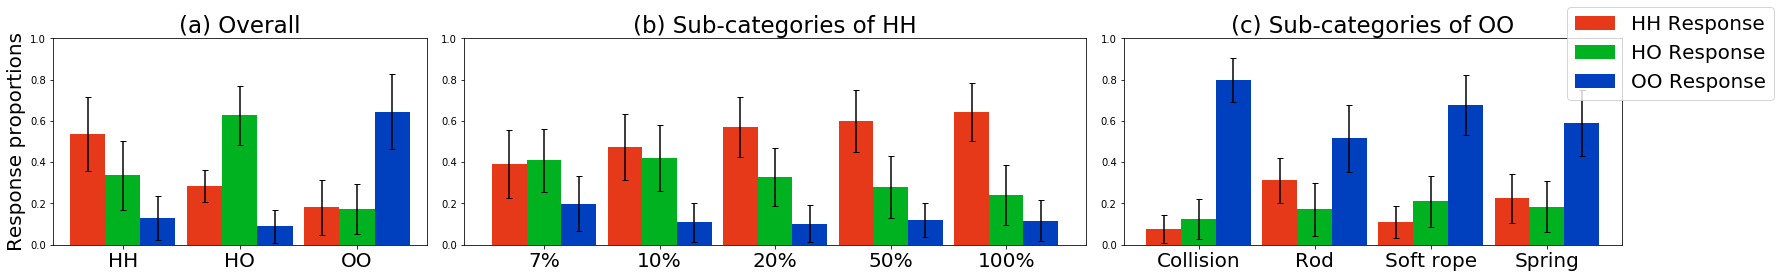

In [13]:
viz_response_hist(HH, HO, OO, GT_types, source='human')